In [1]:
# # IMPORTS
# astronomy
from astropy.io import fits
# plotting 
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import matplotlib.pyplot as plt
import matplotlib as mpl
# data 
import numpy as np
# file IO
import csv
# my python files 
import match
import v2_AGN_DataAndPlotting as adp

# Read Data

In [2]:
# open COSMOS 2020 catalog file and get data 
with fits.open(adp.path_cat+'\\COSMOS2020_CLASSIC_R1_v2.0_master.fits') as hdul20:
    data20 = hdul20[1].data
    cols20 = hdul20[1].columns

In [3]:
# get IRAC data (unit = 'uJy')
ch1_data20  = np.array(data20['SPLASH_CH1_FLUX']) # 3.5686 um
print('.', end='')
ch2_data20  = np.array(data20['SPLASH_CH2_FLUX']) # 4.5067 um
print('.', end='')
ch3_data20  = np.array(data20['SPLASH_CH3_FLUX']) # 5.7788 um
print('.', end='')
ch4_data20  = np.array(data20['SPLASH_CH4_FLUX']) # 7.9958 um 
print('.', end='')
# get ID
id_data20 = np.array(data20['ID_COSMOS2015'])
print('.', end='')

.....

In [4]:
# open COSMOS 2016 catalog file and get data 
with fits.open(adp.path_cat+'\\chandra_COSMOS_legacy_opt_NIR_counterparts_20160113_4d.fits') as hdul16:
    data16 = hdul16[1].data
    cols16 = hdul16[1].columns

In [5]:
# get data arrays from columns
id_data16 = np.array(data16['id_k_uv'])
print('.', end='')
L0510_data16 = np.array(data16['Lx_0510']) # x-ray luminosity in the 0.5-10 KeV band
print('.', end='')
k0510_data16 = np.array(data16['abs_corr_0510'])  # absorbtion correction coefficient in the 0.5-10 KeV band
print('.', end='')

...

In [6]:
# returns array of ( min <= z < max )
def GetRedshiftsInRange(
        zDict,   # dictionary of ID and z  
        min=0,   # minimum
        max=99,  # maximum 
        incusiveMin=False,
        printLength=True
) : 
    # get mask of indecies that are in redshift range (true)
    if(incusiveMin):
        mask = (zDict['z'] >= min) & (zDict['z'] < max)
    else: 
        mask = (zDict['z'] > min) & (zDict['z'] <= max)
    # idolate ID and z
    inRange = {
        'ID' : zDict['ID'][mask] ,
        'z'  : zDict['z'] [mask]
    }
    if(printLength) : 
        if(incusiveMin): 
            print(min, '<= z < ', max, ': ', len(inRange['ID']))
        else:
             print(min, '< z <= ', max, ': ', len(inRange['ID']))       
    return(inRange)

# get redshifts
zDict_all = adp.ReadRedshifts(file=adp.path_cat+'\COSMOS_z_matches.csv')

zDict_split = {
    '$0 < z \leq 1$'   : GetRedshiftsInRange(zDict_all,          max=1  ),
    '$1 < z \leq 1.5$' : GetRedshiftsInRange(zDict_all, min=1,   max=1.5),
    '$1.5 < z \leq 2$' : GetRedshiftsInRange(zDict_all, min=1.5, max=2  ),
    '$2 < z \leq 3$'   : GetRedshiftsInRange(zDict_all, min=2,   max=3  ),
    '$3 < z \leq 6$'   : GetRedshiftsInRange(zDict_all, min=3           )
}

Cropped:  ['ID', 'z']
Number of redshifts: 485793
0 < z <=  1 :  211361
1 < z <=  1.5 :  95993
1.5 < z <=  2 :  57518
2 < z <=  3 :  66963
3 < z <=  99 :  44466


In [7]:
def GetAGNduoFromFile(file, printInfo=True):
    # read AGN IDs
    agnIDs_file = adp.ReadFile(file)
    # convert agnIDs into a dictionary of numpy arrays 
    agnIDs_dict = { 
        'MIR'  : np.array(agnIDs_file[0], dtype=int), 
        'XRAY' : np.array(agnIDs_file[1], dtype=int) 
        }
    # print info
    if(printInfo) :
        print('Number of MIR AGN:\t',    len(agnIDs_dict['MIR']))
        print('Number of Xray AGN:\t',   len(agnIDs_dict['XRAY']))
    # return dict
    return(agnIDs_dict)

# get AGNs
agnIDs = GetAGNduoFromFile(adp.path_csv+'\\v2_AGNid_Xray_MIR.csv')

Cropped:  ['Row 1 = MIR selected AGN (Donley et al, 2012) with id, redshift, IRAC, and 24um (n=880). Row 2 = X-ray selected AGN (Lx > 10^43 erg/s) with id, redshift, IRAC, and 24um (n=1775). ']
Number of MIR AGN:	 880
Number of Xray AGN:	 1775


# Tricolor

In [8]:
def TwoToTri(irID,xrID,printInfo=True):
    # match agn ids to get overlap 
    key_ir, key_xr = match.match(irID, xrID)
    # initialize
    mask_ir = np.ones(irID.size, dtype=bool)
    mask_xr = np.ones(xrID.size, dtype=bool)
    # set matched index to false
    mask_ir[key_ir] = False
    mask_xr[key_xr] = False
    # remove overlaped xray selected agn from ir selected list
    irID_exc = irID[mask_ir]
    # remove overlaped ir selected agn from xray selected list 
    xrID_exc = xrID[mask_xr]
    # create list of ir/xray match
    ixrID_inc = irID[key_ir]
    # create and return dict of list of agn groups
    idDict = {
        'RED' : irID_exc,
        'GRN' : ixrID_inc,
        'BLU' : xrID_exc
    }
    if(printInfo):
        # print info 
        print('Number of IR only:\t',   len(idDict['RED']))
        print('Number of Xray only:\t', len(idDict['BLU']))
        print('Number of matches:\t',   len(idDict['GRN']))
    return(idDict)

# split into RED/YEl/BLU
triID_allZ = TwoToTri(agnIDs['MIR'], agnIDs['XRAY'])

Number of IR only:	 332
Number of Xray only:	 1227
Number of matches:	 548


In [9]:
def GetAGNinZrange(triID, zDict_split, printLengths=True):
    tri_byZ = {}
    for key,zdata in zDict_split.items() :
        # match IDs
        onRED, ZonRED = match.match(triID['RED'], zdata['ID'])
        onGRN, ZonGRN = match.match(triID['GRN'], zdata['ID'])
        onBLU, ZonBLU = match.match(triID['BLU'], zdata['ID'])
        # get dict of ID and redshift split by tricolor
        tri_byZ[key] = {
            'RED' : { 'ID' : triID['RED'][onRED],
                      'z'  : zdata['z'][ZonRED]} ,
            'GRN' : { 'ID' : triID['GRN'][onGRN],
                      'z'  : zdata['z'][ZonGRN]} ,
            'BLU' : { 'ID' : triID['BLU'][onBLU],
                      'z'  : zdata['z'][ZonBLU]}
        }
        if(printLengths) :
            print(key, ': ', 
                  tri_byZ[key]['RED']['ID'].size, 'red,',
                  tri_byZ[key]['GRN']['ID'].size, 'green,',
                  tri_byZ[key]['BLU']['ID'].size, 'blue.'
            )
    return tri_byZ

tri_byZ = GetAGNinZrange(triID_allZ, zDict_split)

$0 < z \leq 1$ :  59 red, 80 green, 301 blue.
$1 < z \leq 1.5$ :  58 red, 123 green, 382 blue.
$1.5 < z \leq 2$ :  67 red, 127 green, 276 blue.
$2 < z \leq 3$ :  108 red, 178 green, 235 blue.
$3 < z \leq 6$ :  40 red, 40 green, 33 blue.


In [10]:
def TriToIRACcolors(
    id_agn,
    id_catalog,
    ch1,    # f_3.6um
    ch2,    # f_4.5 um
    ch3,    # f_5.6um
    ch4     # f_8.0um
):
    # match IDs to data20 
    onCat, onAGN = match.match(id_catalog, id_agn)
    # calculate colors 
    x = adp.IRACx(ch1[onCat], ch3[onCat])
    y = adp.IRACy(ch2[onCat], ch4[onCat]) 
    # return dictionary of IRAC colors by AGN group
    return(x,y)

# calculate IRAC colors for all agn
for keyRange, dataColor in tri_byZ.items() : 
    for keyColor, dataDict in dataColor.items() : # Im sure there is a faster way to do this... O(n^2)
        x,y = TriToIRACcolors(
            dataDict['ID'],
            id_data20,
            ch1_data20,ch2_data20,ch3_data20,ch4_data20 
        )
        dataDict['x'] = x
        dataDict['y'] = y

In [11]:
def PlotDonleyWedge_ax(ax, linewidth=1) : 
    # constants
    x_min = 0.08    # x >= 0.08
    y_min = 0.15    # y >= 0.15
    max = 10        # arbritrary 

    # calculate intercepts
    x_int_ymin = (y_min + 0.27)/1.21  # intercept between y_min and (y>=1.21x-0.27)
    y_int_xmin = (1.21*x_min) + 0.27  # intercept between x_min and (y>=1.21x+0.27)

    # calculate y_low intercepts (y>=1.21x-0.27)
    y1_low = (1.21*x_int_ymin)  - 0.27   
    y2_low = (1.21*max)         - 0.27

    # calculate y_high intercepts (y>=1.21x+0.27)
    y1_high = (1.21*x_min)      + 0.27
    y2_high = (1.21*max)        + 0.27

    # plot lines between intercepts 
    ax.plot( [x_min,       x_min],         [y_min,     y_int_xmin], 'k', linewidth=linewidth)    # x >= 0.08
    ax.plot( [x_min,       x_int_ymin],    [y_min,     y_min],      'k', linewidth=linewidth)    # y >= 0.15
    ax.plot( [x_int_ymin,  max],           [y1_low,    y2_low],     'k', linewidth=linewidth)    # y >= 1.21x - 0.27
    ax.plot( [x_min,       max],           [y1_high,   y2_high],    'k', linewidth=linewidth)    # y <= 1.21x + 0.27

In [12]:
def AddText_z_ax(ax, fullText='', min=-1, max=-1, greaterEqual=False, lessEqual=True, fontsize=adp.SML) :
    # initialize string
    text = ''
    
    # if full text is given
    if(fullText!='') : 
        text = fullText
    # otherwise, build text from parameters 
    else :
        if(min != -1) : # has min
            text += str(min)
            if(greaterEqual) :  text += ' $\leq$ '
            else :              text += ' < '
        text += 'z'
        if(max != -1) : # has max
            if(lessEqual):      text += ' $\leq$ '
            else:               text += ' < '
            text += str(max)

    # add text to axis plot
    ax.text(    0.05,                           # x
                0.93,                           # y 
                text,                           # string
                transform=ax.transAxes,         # use axis coordinants
                horizontalalignment='left',     # alignment 
                fontsize=fontsize               # font size
        )

In [13]:
def PlotTricolor_ax(
    ax,
    x_red, y_red,
    x_grn, y_grn,
    x_blu, y_blu,
    fullText='', z_min=-1, z_max=-1,  greaterEqual=False, lessEqual=True,
):
    # plot data
    ax.scatter(x_blu, y_blu, marker='s', c=adp.c_xray,     s=3, label='Exclusive X-ray (n='+str(len(x_blu))+')')
    ax.scatter(x_red, y_red, marker='^', c=adp.c_ir,       s=3, label='Exclusive MIR (n='+  str(len(x_red))+')')
    ax.scatter(x_grn, y_grn, marker='o', c=adp.c_ir_xray,  s=3, label='Inclusive (n='+      str(len(x_grn))+')')
    PlotDonleyWedge_ax(ax)
    adp.Addtext_n_ax(ax,len(x_blu)+len(x_red)+len(x_grn), pre='$\mathrm{N_{total}}$ = ')
    AddText_z_ax(ax, fullText, z_min, z_max,  greaterEqual, lessEqual)
    # axis settings
    ax.set_aspect('equal')
    ax.set_adjustable('box') 
    ax.set_xlim([-0.7,1.0])
    ax.set_ylim([-0.7,1.0])
    ax.set_xticks([-0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_yticks([-0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    ax.xaxis.set_minor_locator(AutoMinorLocator(2))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))



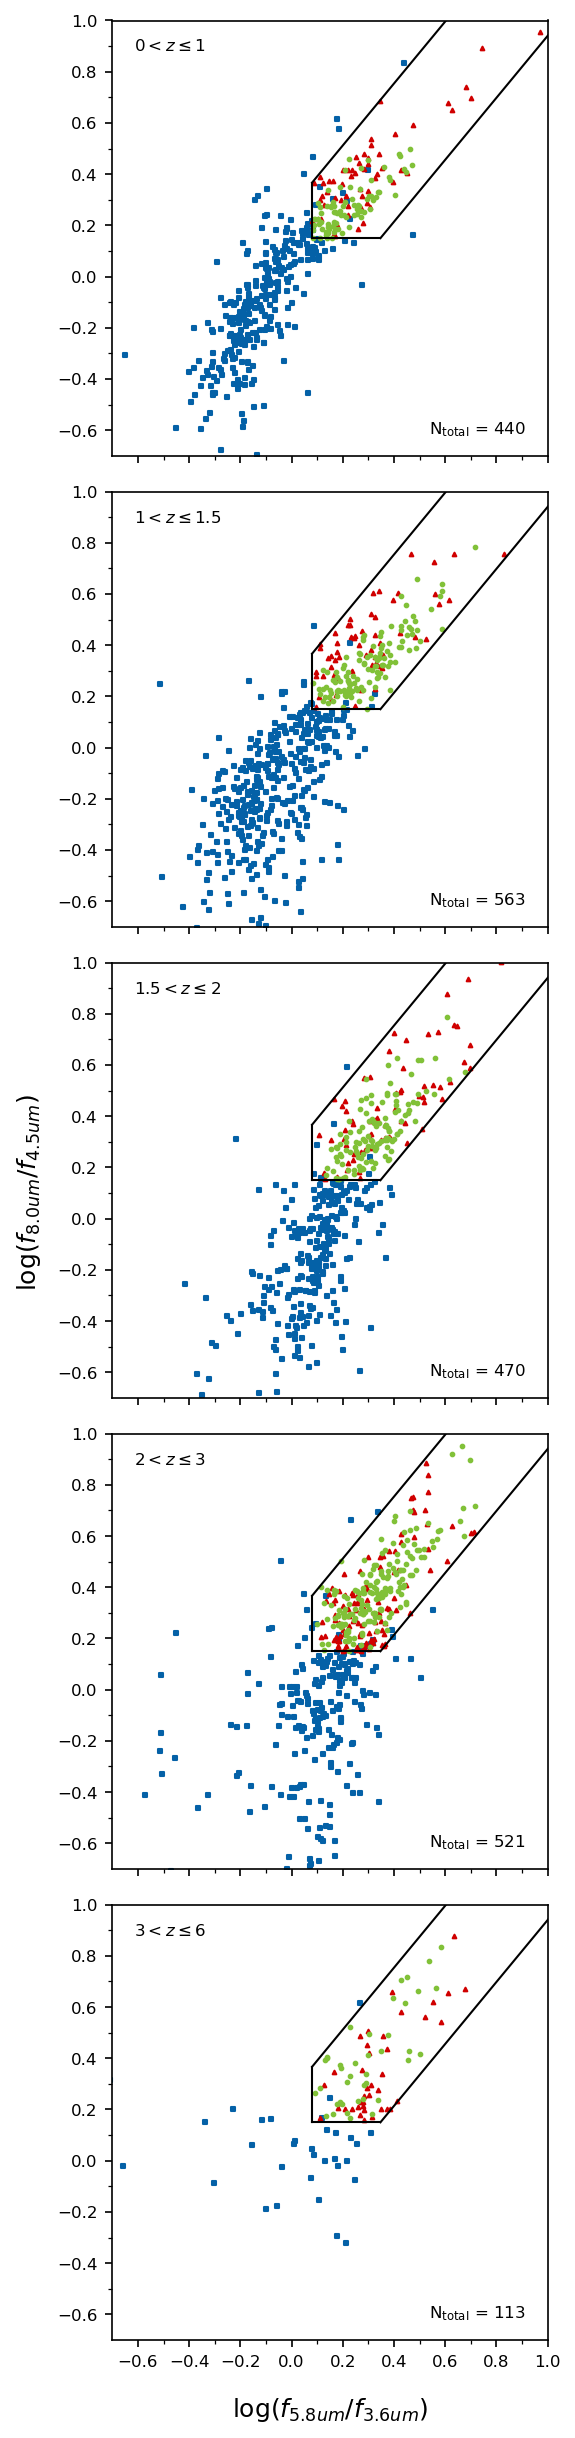

In [14]:
def PlotTricolor_byZ(tri_byZ, save='') : 
    # number of subplots
    n = len(tri_byZ.keys())
    # calculate size using number of subplots
    figsize = (6, 1+(3*n))
    # standardize figure style
    adp.SetStyle() 
    # create figure and axis
    fig, ax = plt.subplots(nrows=n,ncols=1,sharex=True,figsize=figsize,tight_layout=True)
    
    # make plot for each redshift range
    i = 0
    for zrange,color in tri_byZ.items() :
        # plot on axis 
        PlotTricolor_ax(
            ax[i],
            color['RED']['x'], color['RED']['y'], 
            color['GRN']['x'], color['GRN']['y'], 
            color['BLU']['x'], color['BLU']['y'], 
            zrange
        )
        # increment plot
        i+=1

    # name the x and y axis 
    fig.text(0.5, -0.01, '$\log(f_{5.8um}/f_{3.6um})$', ha='center', fontsize=adp.MID)
    fig.text(0.15,  0.5, '$\log(f_{8.0um}/f_{4.5um})$', va='center', fontsize=adp.MID, rotation='vertical')

    if(save):
        adp.Save(save)

    # finish
    plt.show()
    plt.close()

PlotTricolor_byZ(
    tri_byZ,
    save = adp.path_fig + '//v2_colorDiagram_tri_zPanels.png'
)

# X-ray